# Uber Fares Dataset
## Description:
The project is about on world's largest taxi company Uber inc. In this project, we're looking to predict the fare for their future transactional cases. Uber delivers service to lakhs of customers daily. Now it becomes really important to manage their data properly to come up with new business ideas to get best results. Eventually, it becomes really important to estimate the fare prices accurately.

## The datset contains the following fields:
- key - a unique identifier for each trip
- fare_amount - the cost of each trip in usd
- pickup_datetime - date and time when the meter was engaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged

## Acknowledgement:
The dataset is referred from Kaggle.

## Objective:
- Understand the Dataset & cleanup (if required).
- Build Regression models to predict the fare price of uber ride.
- Also evaluate the models & compare thier respective scores like R2, RMSE, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)

import folium
from folium import Marker
from folium.plugins import HeatMap, MarkerCluster

import geopandas as gpd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

import shap

# Import Data

In [2]:
df = pd.read_csv("uber.csv")

In [3]:
df.shape

(200000, 9)

In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
df.drop(["Unnamed: 0","key"], axis = 1, inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


## check missing value

In [7]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

- A missing value in dropoff_longitude, dropoff_latitude.

In [8]:
df = df.dropna()

## split pickup_datetime into year, month, day, weekday and hour

In [9]:
date_time = pd.to_datetime(df["pickup_datetime"]).dt
df["year"] = date_time.year
df["month"] = date_time.month
df["day"] = date_time.day
df["hour"] = date_time.hour
df["weekday"] = date_time.weekday # Monday=0, Sunday=6.

In [10]:
df.drop(["pickup_datetime"],axis = 1, inplace = True)

## summary

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,199999.0,11.359892,9.901760,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,199999.0,-72.527631,11.437815,-1340.648410,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,199999.0,39.935881,7.720558,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,-72.525292,13.117408,-3356.666300,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,39.923890,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,199999.0,1.684543,1.385995,0.000000,1.000000,1.000000,2.000000,208.000000
year,199999.0,2011.742434,1.856400,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
month,199999.0,6.281791,3.438933,1.000000,3.000000,6.000000,9.000000,12.000000
day,199999.0,15.704739,8.687377,1.000000,8.000000,16.000000,23.000000,31.000000
hour,199999.0,13.491387,6.515505,0.000000,9.000000,14.000000,19.000000,23.000000


- `fare_amount` may have input error. Some entries are negative numbers.
- Longitude and latitude have wide range. But in reality,  the range of longitude should be -180 to 180, the range of latitude should be -90 to 90.
- `passenger_count` has minimum of 0 and maximum of 208. Need further investigation.
- `pickup_year` range from 2009 - 2015.

# EDA
## fare_amount

In [12]:
df[df.fare_amount == 0] # transactions with 0 cost

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
20744,0.0,-73.658897,40.805199,-73.658897,40.805199,1,2015,4,22,23,2
22182,0.0,-73.994366,40.755395,-73.998718,40.854853,2,2010,3,20,2,5
87467,0.0,-73.969475,40.807503,0.000000,0.000000,2,2015,1,4,3,6
156738,0.0,-73.937714,40.758541,-73.937721,40.758541,1,2015,2,17,8,1
197172,0.0,0.000000,0.000000,0.000000,0.000000,5,2015,2,13,7,4


- For transactions with zero cost, some are due to missing pickup/ dopoff locations, some are due to zero traveling distance, some are just missing values.

In [13]:
df.drop(index = df[df.fare_amount == 0].index, inplace = True)

In [14]:
df[df.fare_amount < 0].sort_values(by = "fare_amount") # transactions with negative cost

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
98875,-52.00,-74.000359,40.728729,-74.005699,40.728680,5,2015,3,20,21,4
111589,-52.00,-73.984665,40.759026,0.000000,0.000000,5,2015,2,23,19,0
164056,-50.50,-73.784868,40.648677,-73.976975,40.763522,3,2010,3,16,15,1
89322,-49.57,-73.972772,40.785657,-73.972867,40.785500,5,2010,3,9,8,1
92063,-23.70,-73.952740,40.768233,-74.007028,40.707338,3,2010,3,12,8,4
151681,-10.90,-73.964257,40.760630,-73.994222,40.761533,1,2010,2,17,5,2
104080,-7.30,-73.952623,40.766942,-73.953787,40.784882,1,2010,3,9,20,1
139272,-6.90,-73.988727,40.736445,-73.977622,40.750487,1,2010,2,23,18,1
148803,-5.70,-73.977300,40.742783,-73.988837,40.747465,3,2010,2,12,10,4
190925,-5.50,-73.988701,40.742649,-73.985924,40.735001,1,2015,5,1,23,4


In [15]:
df.loc[df[df.fare_amount < 0].index, "fare_amount"] *= -1 # convert negatives to positives

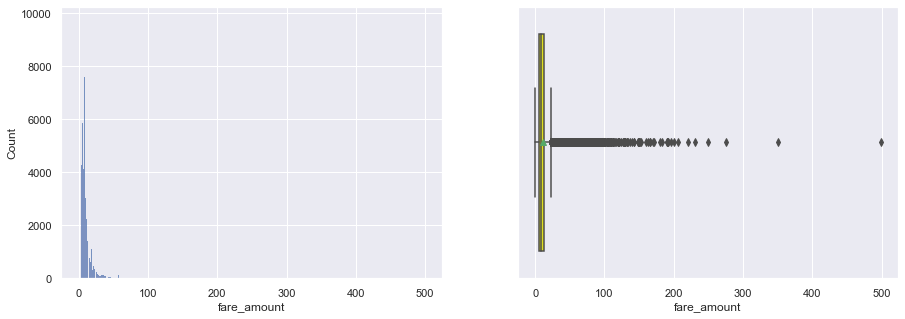

In [16]:
plt.figure(figsize = (15,5));
plt.subplot(121);
sns.histplot(x = df.fare_amount);
plt.subplot(122);
sns.boxplot(x = df.fare_amount, showmeans = True, color = 'yellow');

- Outliers on the upper end. Most of the data points are located between 0 - 200. Take a look at transactions with cost > 200:

In [17]:
df[df["fare_amount"] > 200].sort_values(by = "fare_amount", ascending = False) 

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
170081,499.00,-73.968377,40.764602,-73.968368,40.764600,1,2011,4,10,4,6
4292,350.00,0.000000,0.000000,0.000000,0.000000,3,2014,10,24,20,4
185325,275.00,0.000000,0.000000,0.000000,0.000000,1,2013,4,19,0,4
71715,250.00,0.000000,0.000000,0.000000,0.000000,1,2013,5,11,0,5
197493,230.00,-73.937765,40.758267,-74.382200,40.700890,2,2014,9,7,8,6
29261,220.00,-73.801147,40.671653,-73.790402,40.646742,1,2013,9,27,12,4
23682,206.38,-73.782161,40.644601,-74.449079,40.836457,1,2014,11,2,22,6


- Longitudes or latitudes equal to 0 are missing values.

## passenger_count

In [18]:
df[df.passenger_count == 0] # check records with 0 passenger

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
333,10.1,-74.013900,40.707800,-73.992300,40.749300,0,2011,8,5,7,4
908,11.7,-73.981000,40.764600,-73.962900,40.778400,0,2011,9,6,12,1
926,3.3,-73.979978,40.765821,-73.983894,40.766873,0,2012,3,26,18,0
2000,15.7,-73.975285,40.750138,-73.974729,40.783151,0,2012,4,20,15,4
3011,6.1,-73.977900,40.789100,-73.983700,40.773600,0,2012,1,7,19,5
...,...,...,...,...,...,...,...,...,...,...,...
196797,3.3,-74.000760,40.757637,-74.004852,40.751947,0,2011,1,17,15,0
197103,7.3,0.000000,0.000000,0.000000,0.000000,0,2011,12,10,15,5
198872,5.7,-73.980300,40.742800,-73.967900,40.755600,0,2011,9,20,19,1
198902,12.1,-73.996700,40.737200,-74.008500,40.704000,0,2011,8,22,21,0


- Regarding the fare_amount and difference between pickup, dropoff locations, records with 0 passengers should be missing values.

In [19]:
df.loc[df[df.passenger_count == 0].index, "passenger_count"] = np.nan

In [20]:
df.sort_values(by = "passenger_count", ascending = False)[:10]  # check first 10 records with large passenger_count

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
113038,11.7,-73.937795,40.758498,-73.937835,40.758415,208.0,2010,12,28,8,1
70468,12.5,-73.980202,40.764117,-73.966200,40.807352,6.0,2012,1,6,7,4
178863,9.0,-73.993225,40.757757,-73.980115,40.738360,6.0,2013,5,27,9,0
108601,11.0,-73.958110,40.761070,-73.990190,40.771645,6.0,2013,8,28,8,2
23948,14.5,-73.982532,40.731447,-73.959805,40.780352,6.0,2013,8,17,11,5
76813,8.5,0.000000,0.000000,0.000000,0.000000,6.0,2014,8,4,12,0
19296,10.5,-73.977587,40.752107,-73.989152,40.776840,6.0,2012,9,16,21,6
165005,7.3,-73.959837,40.747277,-73.953928,40.728643,6.0,2009,5,6,8,2
83891,9.0,-74.004280,40.742467,-73.997920,40.726270,6.0,2013,2,7,17,3
37015,18.5,-74.004100,40.752887,-73.951097,40.791485,6.0,2013,7,8,22,0


- Only one row has `passenger_count` significantly larger than others, which is 208.
- Compared to other rows with similar fare_amount and pickup/ dropoff locations, it's probably an entry error. Mark it as missing value:

In [21]:
df.loc[113038, "passenger_count"] = np.nan

In [22]:
def count_plot(col):
    ax = sns.countplot(x = col, data = df);
    for p in ax.patches:
        perc = np.round(100 * p.get_height() / df.shape[0], 2)
        plt.annotate(text = "{}%".format(perc), xy = (p.get_x(), p.get_height()));

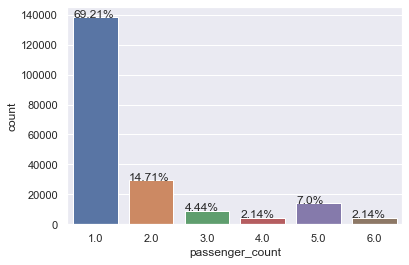

In [23]:
count_plot("passenger_count")

- One or two passengers in most cases.

## year

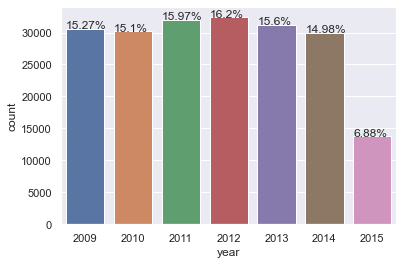

In [24]:
count_plot("year")

- Data between 2009 - 2014 are evenly distributed. Data in 2015 is significantly less than other years.

## month

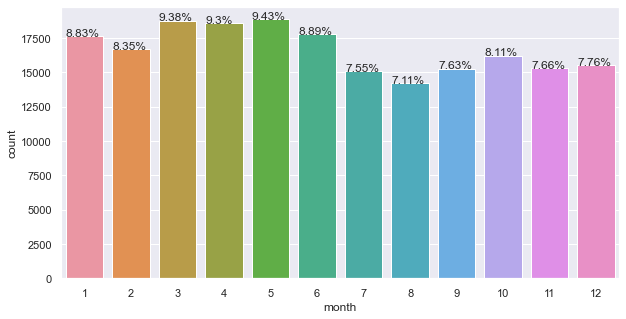

In [25]:
plt.figure(figsize = (10,5));
count_plot("month")

- More records from first half year than that from second half year.

## day

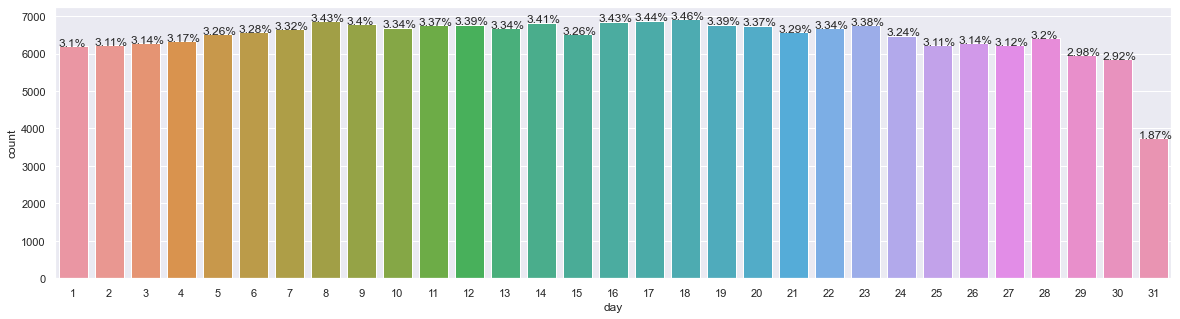

In [26]:
plt.figure(figsize = (20,5));
count_plot("day")

- Data is almost evenly distributed among 1st - 30th day. Data from 31th day is less than the others, due to the reason that only half of the months have 31th day.

## weekday

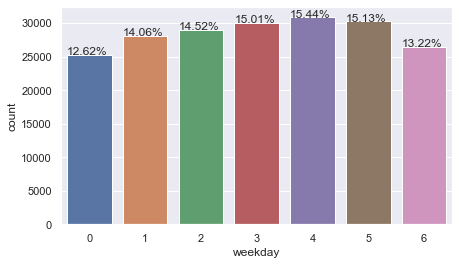

In [27]:
plt.figure(figsize = (7,4));
count_plot("weekday")

- Less records from Monday or Sunday.

## hour

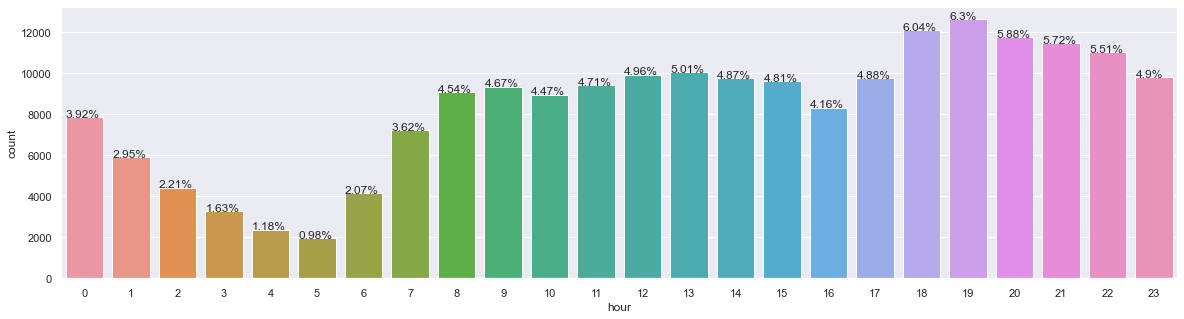

In [28]:
plt.figure(figsize = (20,5));
count_plot("hour")

- Most trips occur at evening(18:00 - 22:00).
- Few trips occur at early morning (1:00 - 5:00).

## longitude and latitude

In [29]:
missing_geometry = df[(df.pickup_longitude == 0) | (df.pickup_latitude == 0) | (df.dropoff_longitude == 0) 
                      | (df.dropoff_latitude == 0)]
print("Rows with missing logitude/ latitude: {}, accounting for {} % of the total transactions. ".format 
            (missing_geometry.shape[0],np.round(100 * missing_geometry.shape[0] / df.shape[0], 2)))

Rows with missing logitude/ latitude: 3966, accounting for 1.98 % of the total transactions. 


In [30]:
df.drop(index = missing_geometry.index, inplace = True)   # drop missing longitude and latitude
df = df[(df.pickup_longitude >= -180) & (df.pickup_longitude <= 180) & (df.pickup_latitude >= -90) &
        (df.pickup_latitude <= 90) & (df.dropoff_longitude >= -180) & (df.dropoff_longitude <= 180) &
        (df.dropoff_latitude >= -90) & (df.dropoff_latitude <= 90)].reset_index(drop = True)  # drop incorrect longitude and latitude

In [31]:
df.shape

(196016, 11)

In [32]:
# m1 = folium.Map(location = [df["pickup_latitude"].mean(), df["pickup_longitude"].mean()], 
#                 title = "locations", zoom_start = 13)
# mc = MarkerCluster()
# for i, r in df.iterrows():
#     mc.add_child(Marker(location = [r["pickup_latitude"],r["pickup_longitude"]], icon=folium.Icon(color="green")))  # pickup: green
#     mc.add_child(Marker(location = [r["dropoff_latitude"],r["dropoff_longitude"]], icon=folium.Icon(color="red")))   # dropoff: red
# m1.add_child(mc)
# m1

- Locations are mainly in US, especially around New York City. A few are located at Europe and South America. The remainings don't seem valid.

## add holiday_month column

In [33]:
holiday_months = [1,2,5,7,9,11,12] # new year, president's day, memorial day, independence day, labor day, Thanksgiving, Christma
df["holiday_month"] = df.month.isin(holiday_months)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,holiday_month
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,2015,5,7,19,3,True
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,2009,7,17,20,4,True
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,2009,8,24,21,0,False
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,2009,6,26,8,4,False
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5.0,2014,8,28,17,3,False


## add distance column

In [34]:
# set the CRS. EPSG 4326 corresponding to coordinates in latitude and longitude.
pickup = gpd.GeoSeries(data=gpd.points_from_xy(df["pickup_longitude"], df["pickup_latitude"]), crs="EPSG:4326")
dropoff = gpd.GeoSeries(data=gpd.points_from_xy(df["dropoff_longitude"], df["dropoff_latitude"]), crs="EPSG:4326")

In [35]:
# re-project to World Azimuthal Equidistant projection
distance = pickup.to_crs("ESRI:54032").distance(dropoff.to_crs("ESRI:54032"))
df["distance"] = distance/1000  # distance in km

In [36]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,holiday_month,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,2015,5,7,19,3,True,2.318313
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,2009,7,17,20,4,True,3.385551
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,2009,8,24,21,0,False,6.435003
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,2009,6,26,8,4,False,2.226913
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5.0,2014,8,28,17,3,False,4.616449


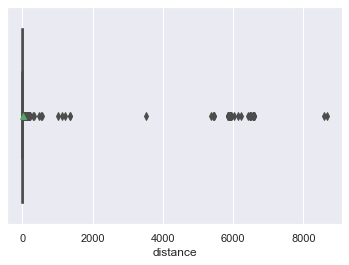

In [37]:
# plt.figure(figsize = (15,5));
# plt.subplot(121);
# sns.histplot(x = "distance", data = df);
# plt.subplot(122);
sns.boxplot(x = "distance", showmeans = True, color = "yellow", data = df);

- Most distances are less than 1000 km. Let's check those outliers:

In [38]:
large_distance = df[df.distance > 1000].sort_values("distance",ascending = False)
large_distance

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,holiday_month,distance
69516,4.5,-73.999647,40.768180,0.000213,-0.000013,1.0,2009,6,2,16,1,False,8668.029518
126698,10.1,-0.128333,0.966785,-74.000577,40.762683,1.0,2012,5,11,13,4,True,8586.409019
51923,10.5,-73.987150,40.687925,-0.050000,40.712542,6.0,2012,8,7,11,1,False,6587.002629
11661,14.9,-0.007712,40.725602,-73.967487,40.766410,5.0,2012,2,26,0,6,True,6584.193457
141203,6.1,-73.997260,40.731502,-0.066667,40.728990,1.0,2012,5,27,13,6,True,6583.353618
58542,7.3,-0.066667,40.739207,-74.004487,40.741702,2.0,2012,4,21,1,5,False,6583.116734
171759,12.1,-73.989282,40.736092,-0.116667,40.752877,5.0,2012,1,24,23,1,True,6577.400605
1903,7.0,-0.131667,40.757063,-73.991593,40.749953,1.0,2013,2,10,16,6,True,6575.311772
135317,2.9,-73.977795,40.757315,-0.116667,40.754547,1.0,2011,9,5,19,0,True,6575.139435
75530,12.5,-73.973397,40.784545,-0.116667,40.750467,1.0,2011,10,11,9,1,False,6573.221788


- These records are problematic. Some with pickup and dropoff locations in different countries, like from Colombia to US. Some, though with both locations in US, take 10+ hours to travel by car. It doesn't make sense given the fares are so low. Such records should be dropped.

In [39]:
print("Rows with outlier distance: {}, accounting for {:.2f}% of total records.".format
      (large_distance.shape[0], large_distance.shape[0] * 100 / df.shape[0]))

Rows with outlier distance: 44, accounting for 0.02% of total records.


In [40]:
df.drop(index = large_distance.index, inplace = True)
df.shape

(195972, 13)

In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,195972.0,11.345984,9.797371,0.010000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,195972.0,-73.908995,2.705108,-77.316665,-73.992268,-73.982102,-73.968321,40.808425
pickup_latitude,195972.0,40.688094,2.640823,-74.015515,40.736397,40.753287,40.767537,45.031653
dropoff_longitude,195972.0,-73.908071,2.705106,-75.458979,-73.991592,-73.980522,-73.965320,40.831932
dropoff_latitude,195972.0,40.688347,2.641161,-74.015750,40.735274,40.753726,40.768326,45.031598
passenger_count,195285.0,1.689997,1.305930,1.000000,1.000000,1.000000,2.000000,6.000000
year,195972.0,2011.739575,1.859058,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
month,195972.0,6.282413,3.439873,1.000000,3.000000,6.000000,9.000000,12.000000
day,195972.0,15.705039,8.688442,1.000000,8.000000,16.000000,23.000000,31.000000
hour,195972.0,13.490871,6.514480,0.000000,9.000000,14.000000,19.000000,23.000000


## correlation

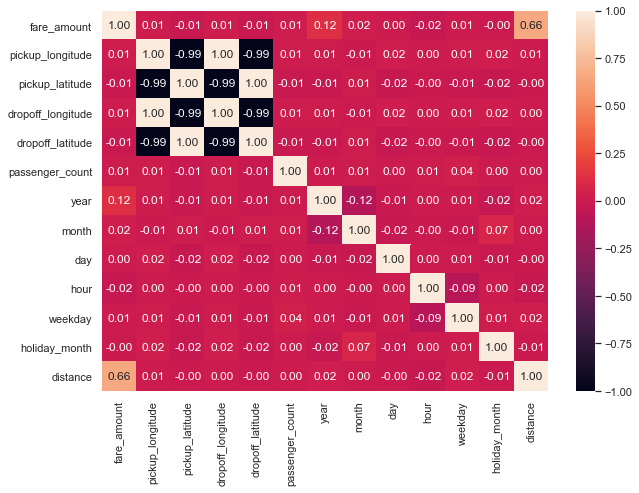

In [42]:
plt.figure(figsize = (10,7));
sns.heatmap(df.corr(), annot = True, fmt = ".2f", vmin = -1, vmax = 1);

- longitudes and latitudes have high correlation.
- fare_amount and distance are highly correlated.

## fare_amount vs distance

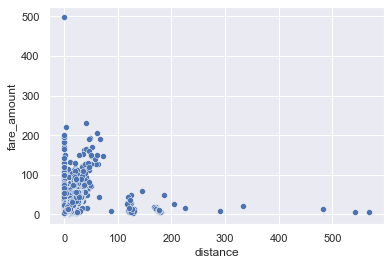

In [43]:
sns.scatterplot(x = "distance", y = "fare_amount", data = df);

- Positive correlation between fare and distance. Check the transaction with the highest fare:

In [44]:
df[df.fare_amount == 499]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,holiday_month,distance
166672,499.0,-73.968377,40.764602,-73.968368,40.7646,1.0,2011,4,10,4,6,False,0.000796


- The one with the highest fare turns out has distance < 1m, which is problematic. Drop it.

In [45]:
df.drop(index = df[df.fare_amount == 499].index, inplace = True)

- Check transactions with distance > 100 km:

In [46]:
df[df.distance > 100].sort_values("distance", ascending = False)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,holiday_month,distance
195432,7.00,-67.370360,39.999790,-73.971058,40.753000,1.0,2013,1,20,17,6,True,567.893293
183690,7.30,-67.679123,40.061852,-73.989387,40.753045,1.0,2011,10,1,11,5,False,542.350433
129924,14.50,-74.007223,40.715879,-72.861433,37.533090,1.0,2012,10,10,18,2,False,483.411457
172440,20.50,-73.955800,40.772690,-71.718700,42.424147,1.0,2014,3,17,13,0,False,333.679691
115939,9.70,-77.316665,40.800965,-73.924625,40.822872,3.0,2012,2,28,22,1,True,290.275588
36405,17.30,-73.967302,40.759383,-75.458979,39.653763,1.0,2011,5,28,7,5,True,224.984738
24278,27.30,-75.426904,40.774075,-73.971779,39.622013,1.0,2011,2,17,18,3,True,205.387236
193551,49.80,-75.342288,40.646767,-73.976186,39.615770,1.0,2011,5,9,13,0,True,186.705078
99228,7.30,-73.978697,40.777357,-73.962233,39.603429,1.0,2011,3,29,10,1,False,179.683547
153546,4.90,-73.950460,40.771599,-73.960290,39.606012,1.0,2011,2,8,19,1,True,178.648849


- Several transactions with distance > 100 km and fare < \\$50 also seem to be problematic.
- Check transactions with distance = 0 and fare > 0:

In [47]:
df[(df.distance == 0) & (df.fare_amount != 0)]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,holiday_month,distance
5,4.90,-73.969019,40.755910,-73.969019,40.755910,1.0,2011,2,12,2,5,True,0.0
46,56.80,-73.993498,40.764686,-73.993498,40.764686,1.0,2013,1,3,22,3,True,0.0
81,49.57,-73.975058,40.788820,-73.975058,40.788820,1.0,2009,8,7,10,4,False,0.0
160,4.50,-73.992937,40.757780,-73.992937,40.757780,1.0,2014,1,22,21,2,True,0.0
352,10.10,-73.928705,40.753475,-73.928705,40.753475,1.0,2009,8,24,17,0,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195477,5.70,-73.924907,40.745833,-73.924907,40.745833,3.0,2010,7,24,21,5,True,0.0
195640,4.50,-73.969717,40.765832,-73.969717,40.765832,3.0,2013,2,17,11,6,True,0.0
195672,2.50,-73.956623,40.771633,-73.956623,40.771633,1.0,2009,6,7,2,6,False,0.0
195935,4.50,-73.793768,40.656939,-73.793768,40.656939,1.0,2013,6,24,22,0,False,0.0


In [48]:
df.drop(index = df[((df.distance > 100) & (df.fare_amount < 50)) | ((df.distance == 0) & (df.fare_amount != 0))].index, inplace = True)

Update the plot:

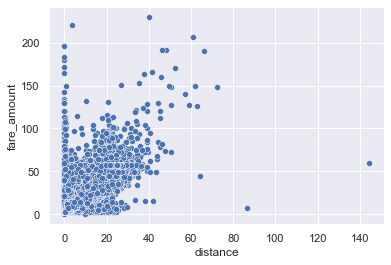

In [49]:
sns.scatterplot(x = "distance", y = "fare_amount", data = df);

In [50]:
df.shape

(193873, 13)

## fare_amount vs datetime

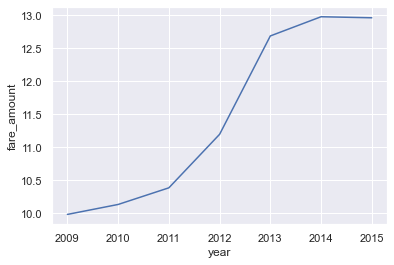

In [51]:
sns.lineplot(data = df.groupby(by = "year")["fare_amount"].mean());

- Average fare increases over year, from \\$10.00 per trip in 2009 to \\$13.00 per trip in 2015.

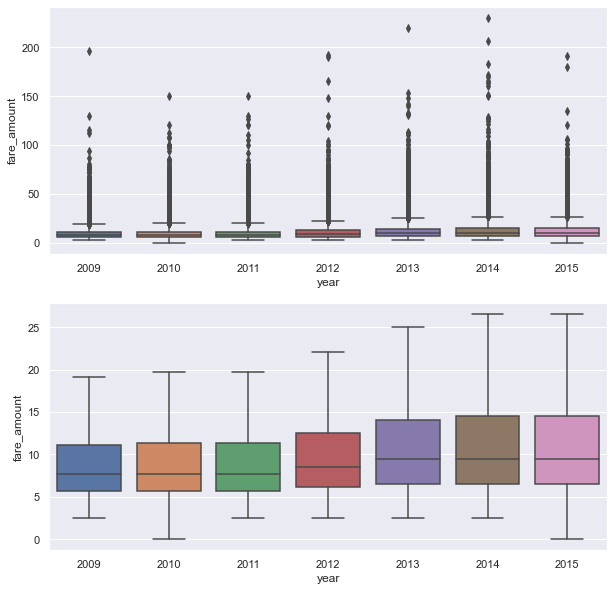

In [52]:
plt.figure(figsize = (10,10))
plt.subplot(211)
sns.boxplot(x = "year", y = "fare_amount", data=df);
plt.subplot(212)
sns.boxplot(x = "year", y = "fare_amount", data=df, showfliers = False);

- The variation of cost increases over year.

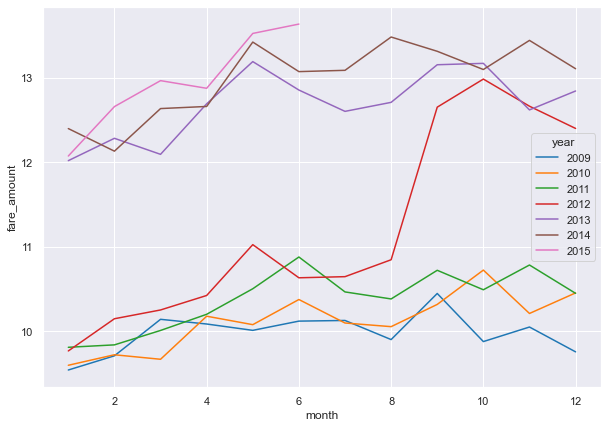

In [53]:
plt.figure(figsize = (10,7))
sns.lineplot(x = "month",y = "fare_amount",data = df, hue= "year",palette="tab10" ,ci=None);

- For 2015, We only have data from Jan - June. That's why the data from 2015 is less than other years and why data from 1st half year is more than that from 2nd half year.
- The 2nd half year in 2012 sees a hike in the cost of Uber.

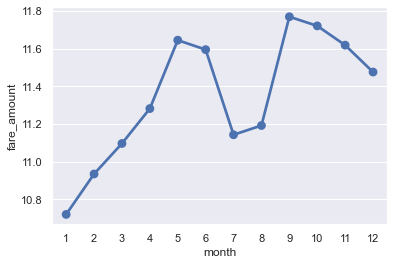

In [54]:
sns.pointplot(x = "month", y = "fare_amount", data = df, ci = None);

- Highest fare in September, May and June. Lowest fare in January.

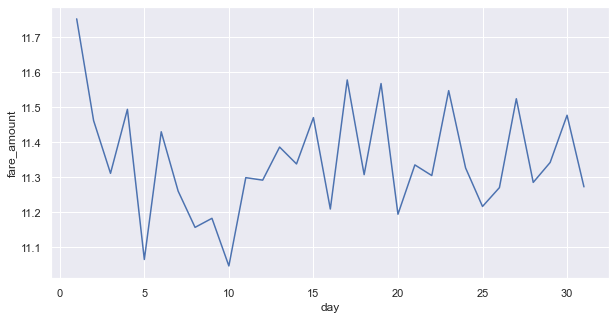

In [55]:
plt.figure(figsize = (10,5));
sns.lineplot(x = "day", y = "fare_amount", data = df, ci = None);

- Fare at the beginning of the month is slightly higher than other days.

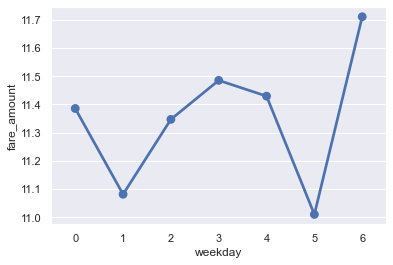

In [56]:
sns.pointplot(x = "weekday", y = "fare_amount", data = df, ci = None);

- fare is the highest on Sunday and lowest on Saturday.

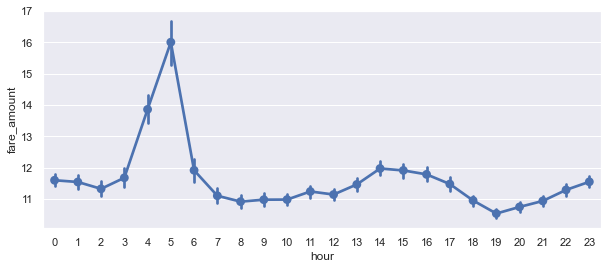

In [57]:
plt.figure(figsize = (10,4));
sns.pointplot(x = "hour", y = "fare_amount", data = df);

- Fare at 4:00 - 5:00 is higher than other time. Fare at 18:00 - 21:00 is lower than other time.

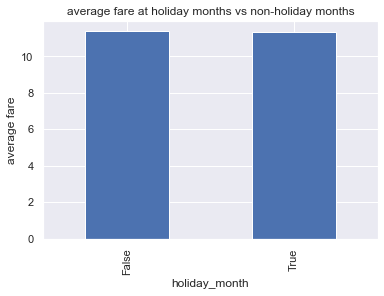

In [58]:
df.groupby("holiday_month")["fare_amount"].mean().plot.bar();
plt.ylabel("average fare");
plt.title("average fare at holiday months vs non-holiday months");

- Little difference in fare between holiday months and non-holiday months.

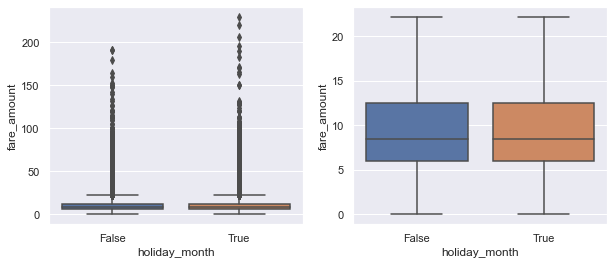

In [59]:
plt.figure(figsize = (10,4));
plt.subplot(121);
sns.boxplot(x = "holiday_month", y = "fare_amount", data = df);
plt.subplot(122);
sns.boxplot(x = "holiday_month", y = "fare_amount", showfliers = False, data = df);

## passenger_count vs datetime

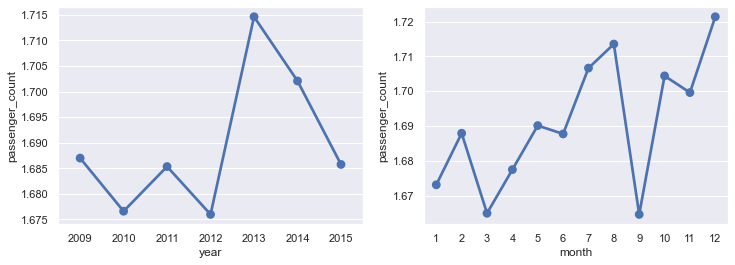

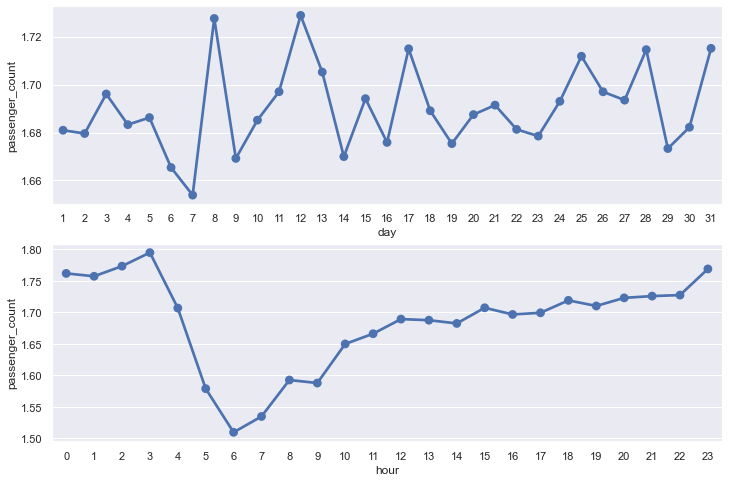

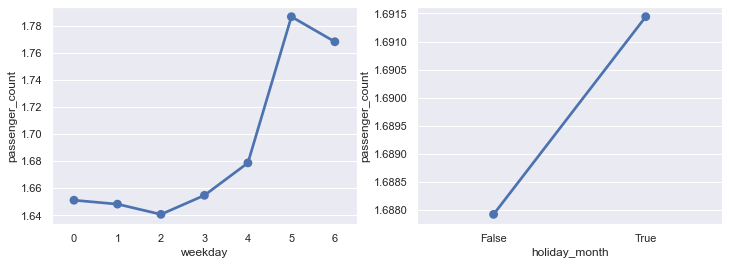

In [60]:
plt.figure(figsize = (12,4));
plt.tight_layout();
plt.subplot(121);
sns.pointplot(x = "year", y = "passenger_count", data = df, ci = None);
plt.subplot(122);
sns.pointplot(x = "month", y = "passenger_count", data = df, ci = None);

plt.figure(figsize = (12,8));
plt.tight_layout();
plt.subplot(211);
sns.pointplot(x = "day", y = "passenger_count", data = df, ci = None);
plt.subplot(212);
sns.pointplot(x = "hour", y = "passenger_count", data = df, ci = None);

plt.figure(figsize = (12,4));
plt.tight_layout();
plt.subplot(121);
sns.pointplot(x = "weekday", y = "passenger_count", data = df, ci = None);
plt.subplot(122);
sns.pointplot(x = "holiday_month", y = "passenger_count", data = df, ci = None);

- The average number of passengers per trip doesn't change much between 2009 - 2015.
- More passengers per trip in August and December, which may be due to families travelling by Uber during summer vacations and holiday seasons. September sees least passengers per trip.
- The average number of passengers per trip doesn't change much by day, but it varies significantly by hour. Trips in early morning have more passengers, while trips at around 6:00 have least passengers.
- Weekends see more passengers per trip.

## fare_amount vs passenger_count

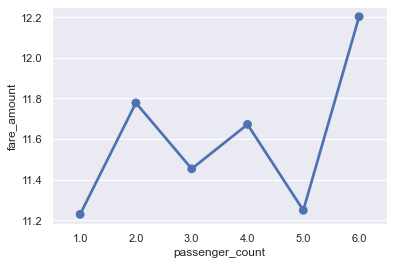

In [61]:
sns.pointplot(x = "passenger_count", y = "fare_amount", data = df, ci = None);

- Highest cost when the number of passengers per trip is 6.

## hot spot to pick up

In [62]:
# m2 = folium.Map(location = [df["pickup_latitude"].mean(), df["pickup_longitude"].mean()], title = "pickup_heatmap", zoom_start = 13)
# HeatMap(data = df[["pickup_latitude", "pickup_longitude"]], radius = 10).add_to(m2)
# m2

- Pickup mostly occur at Manhattan.

## hot spot to drop off

In [63]:
# m3 = folium.Map(location = [df["dropoff_latitude"].mean(), df["dropoff_longitude"].mean()], title = "dropoff_heatmap", zoom_start = 13)
# HeatMap(data = df[["dropoff_latitude", "dropoff_longitude"]], radius = 10).add_to(m3)
# m3

- Although Manhattan is still one of the hot spots of drop off, areas to the south, east and north of Manhattan are also hot spots.

# Data preparation

In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,193873.0,11.344961,9.669717,0.010000,6.000000,8.500000,12.500000,230.000000
pickup_longitude,193873.0,-73.910644,2.685066,-75.387785,-73.992279,-73.982130,-73.968460,40.808425
pickup_latitude,193873.0,40.688499,2.629351,-74.015515,40.736440,40.753288,40.767527,45.031653
dropoff_longitude,193873.0,-73.909668,2.685155,-75.417737,-73.991600,-73.980568,-73.965520,40.831932
dropoff_latitude,193873.0,40.688810,2.629677,-74.015750,40.735306,40.753733,40.768325,45.031598
passenger_count,193187.0,1.689938,1.305616,1.000000,1.000000,1.000000,2.000000,6.000000
year,193873.0,2011.745452,1.860159,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
month,193873.0,6.281695,3.440562,1.000000,3.000000,6.000000,9.000000,12.000000
day,193873.0,15.704750,8.687843,1.000000,8.000000,16.000000,23.000000,31.000000
hour,193873.0,13.487809,6.515775,0.000000,9.000000,14.000000,19.000000,23.000000


In [65]:
stats_missing = pd.DataFrame(df.isnull().sum(), columns = ["Number_missing_values"])
stats_missing["%"] = np.round(stats_missing["Number_missing_values"] / df.shape[0] * 100, 2)
stats_missing[stats_missing.Number_missing_values > 0]

,Number_missing_values,%
passenger_count,686,0.35


## split data

In [66]:
X = df.copy()
y = X.pop("fare_amount")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 62)

## imputation

In [67]:
val = X_train["passenger_count"].mode()[0]
X_train = X_train.fillna(val)
X_test = X_test.fillna(val)

## outlier treatment
- As we discover in the EDA section, most of `fare_amount` range from 0 - 200. 

In [68]:
y_train.clip(upper=200, inplace=True)
y_test.clip(upper=200, inplace=True)

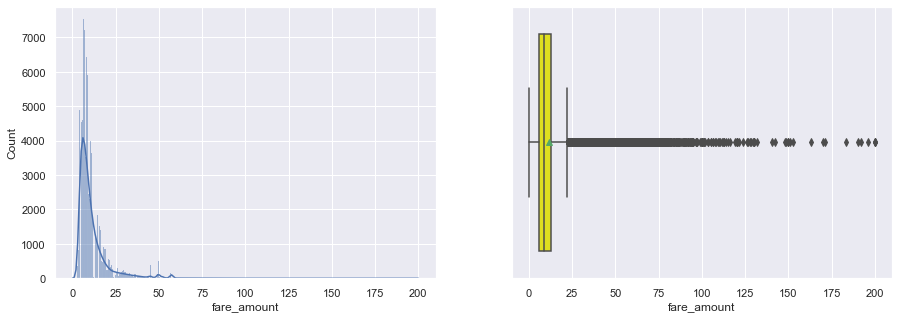

In [69]:
plt.figure(figsize = (15,5));
plt.subplot(121);
sns.histplot(x = y_train, kde = True);
plt.subplot(122);
sns.boxplot(x = y_train, showmeans = True, color = "yellow");

## column transform

In [70]:
num_columns = ["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","distance"]
cat_columns = ["year","month", "day", "hour", "weekday", "holiday_month"]

ct = ColumnTransformer(transformers = [("encoder", OneHotEncoder(drop='first'), cat_columns),("scaler", StandardScaler(), num_columns)], 
                           remainder = "passthrough", n_jobs = -1)
X_train = ct.fit_transform(X_train).toarray()
X_test = ct.transform(X_test).toarray()

In [71]:
print(X_train.shape, X_test.shape)

(155098, 83) (38775, 83)


In [72]:
column_names = list(ct.transformers_[0][1].get_feature_names_out(cat_columns)) + list(ct.transformers_[1][1].get_feature_names_out(num_columns))
len(column_names)

83

# Model Building

In [73]:
def metrics(model, X_train, y_train, X_test, y_test):
    model = model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared = False)

    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared = False)
    
    print("Train: R2: {0:.3f}, RMSE: {1:.3f}".format(r2_train, rmse_train))
    print("Test: R2: {0:.3f}, RMSE: {1:.3f}".format(r2_test, rmse_test))
    return model

## Linear Regression
### Linear regression without high multicollinear features

- Based on EDA, we found some predictors with high multicolinearity. Before applying linear regression, let's check variance inflation factor (VIF):

In [74]:
def compute_vif(column_idx):
    vif = []
    for i in column_idx:
        vif.append(variance_inflation_factor(X_train, i))
 
    return pd.DataFrame({"column":column_names, "vif":vif})

In [75]:
column_idx = list(range(len(column_names)))
vif_df = compute_vif(column_idx)
vif_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82
column,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_month_True,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
vif,1.679326,1.707411,1.715522,1.70505,1.68035,1.42284,1.795145,7.516743,7.449819,1.876213,7.14941,1.730937,5.818859,1.740323,6.649337,1.746709,1.752368,1.940979,1.946869,1.95234,1.978844,1.995,1.999847,2.043393,2.018404,2.016833,2.021566,2.02374,2.010091,2.026952,1.988304,2.036038,2.041582,2.045204,2.022001,2.006623,1.996572,2.016645,2.018728,1.972564,1.931207,1.946986,1.939603,1.968067,1.910708,1.882038,1.59318,1.69579,1.518287,1.398721,1.292682,1.240129,1.508229,1.869907,2.088172,2.106246,2.05544,2.104292,2.161189,2.175347,2.142678,2.121526,1.973793,2.14462,2.410226,2.453411,2.379397,2.324254,2.283521,2.149752,1.827857,1.84479,1.868547,1.88992,1.903432,1.829335,46.572243,4256.103302,6845.260905,4245.407082,6812.430971,1.004576,1.022437


- VIF of longitude, latitude, holiday_month_True are much larger than 5. Remove all columns with VIF > 5.

In [76]:
column_idx = vif_df[vif_df.vif <= 5].index.to_list()

In [77]:
print("{} features remain:{}".format(len(column_idx), column_idx))

73 features remain:[0, 1, 2, 3, 4, 5, 6, 9, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 81, 82]


- Dropping 10 features, now with 73 features we apply linear regression: 

In [78]:
lr = LinearRegression(n_jobs = -1)
lr = metrics(lr, X_train[:,column_idx], y_train, X_test[:,column_idx], y_test)

Train: R2: 0.735, RMSE: 4.973
Test: R2: 0.723, RMSE: 5.073


- No overfitting. R2 is about 0.72. RMSE is about 5.07.

In [79]:
pd.DataFrame({"coef":lr.coef_}, index = [column_names[i] for i in column_idx]).sort_values("coef", ascending = False).T

,distance,year_2015,year_2014,year_2013,hour_14,hour_15,hour_11,hour_13,hour_12,hour_16,hour_9,hour_17,hour_10,hour_8,hour_18,hour_5,year_2012,month_9,month_12,hour_19,month_11,weekday_3,weekday_4,weekday_2,hour_7,day_23,weekday_1,day_21,hour_20,day_12,day_7,year_2011,day_14,month_5,passenger_count,hour_23,day_2,day_13,day_30,day_24,day_17,day_22,day_26,day_31,day_16,day_27,day_15,day_20,year_2010,day_6,day_9,day_19,day_4,hour_21,hour_22,day_8,day_28,day_10,day_18,day_3,day_25,day_11,month_7,day_5,day_29,weekday_5,weekday_6,hour_4,month_2,hour_6,hour_2,hour_1,hour_3
coef,8.219996,2.621433,2.420999,2.129755,1.535334,1.477842,1.357567,1.322968,1.297362,1.218385,1.213182,1.180715,1.164824,0.965732,0.913968,0.858453,0.65398,0.587798,0.523373,0.494275,0.478587,0.415597,0.402526,0.361256,0.209073,0.200824,0.156967,0.152159,0.151918,0.12049,0.094078,0.08553,0.078979,0.075447,0.064375,0.052556,0.045049,0.038221,0.037856,0.033836,0.029156,0.025295,0.024235,0.023618,0.019332,0.017148,0.009826,0.009207,-0.005419,-0.009424,-0.012416,-0.020477,-0.029475,-0.038301,-0.040092,-0.049548,-0.062595,-0.067581,-0.070042,-0.082114,-0.084589,-0.08511,-0.087456,-0.097496,-0.105501,-0.127469,-0.132238,-0.137377,-0.190758,-0.279867,-0.347075,-0.353167,-0.446972


### Linear regression with PCA
- Since the number of features in the original dataset is as large as 83 and some of them are highly correlated, let's try to extract the most important ones by PCA.

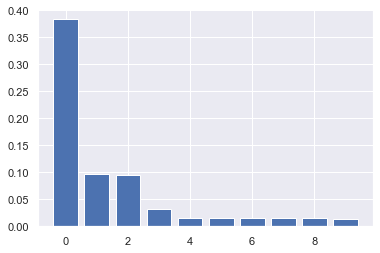

In [80]:
pca = PCA(n_components=10, random_state = 2)
pca.fit(X_train, y_train)
plt.bar(x = np.arange(len(pca.explained_variance_ratio_)), height = pca.explained_variance_ratio_);

- Only the first four components show significant explained_variance, and the first 10 components totally account for 70% variance:

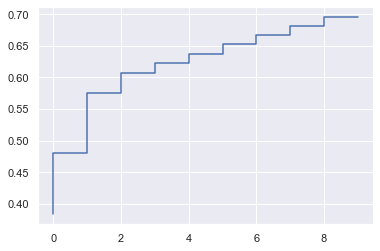

In [81]:
plt.step(x = np.arange(len(pca.explained_variance_ratio_)),y = np.cumsum(pca.explained_variance_ratio_), where = 'pre');

In [82]:
lr_pca = LinearRegression(n_jobs = -1)
lr_pca = metrics(lr_pca, pca.transform(X_train), y_train, pca.transform(X_test), y_test)

Train: R2: 0.726, RMSE: 5.058
Test: R2: 0.714, RMSE: 5.158


- We manage to achieve similar performance on only 10 predictors after PCA.

### Linear regression with feature selector
- Use Recursive feature elimination with cross-validation to select the number of features from 83 features in the original dataset.

In [83]:
selector = RFECV(estimator = LinearRegression(n_jobs = -1), cv=3, scoring="r2", n_jobs = -1).fit(X_train, y_train)

In [84]:
pd.DataFrame({"selected": selector.support_, "ranking": selector.ranking_}, index = column_names).sort_values(by = "ranking").T

,distance,pickup_latitude,pickup_longitude,hour_12,hour_11,hour_10,hour_9,holiday_month_True,hour_8,hour_6,hour_5,weekday_1,day_21,weekday_4,day_23,hour_3,hour_2,hour_1,hour_13,weekday_3,dropoff_longitude,dropoff_latitude,hour_19,year_2012,year_2013,year_2014,year_2015,hour_18,month_3,month_4,hour_14,month_5,hour_17,month_8,month_9,month_10,month_11,month_12,hour_16,hour_15,month_6,weekday_2,day_12,hour_21,hour_22,month_7,weekday_6,weekday_5,day_7,day_14,year_2011,hour_7,day_29,day_5,day_25,day_11,day_3,day_10,day_18,passenger_count,hour_20,month_2,day_13,day_2,day_30,day_24,day_16,day_31,day_17,day_26,day_22,day_27,day_15,day_20,day_28,day_8,hour_4,day_4,year_2010,day_6,day_19,hour_23,day_9
selected,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42


In [85]:
selector.n_features_

42

- The selector suggests to keep only 42 features of rank 1.

In [86]:
selected_idx = selector.get_support(True)
selected_idx

array([ 2,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 36, 38, 47, 48,
       49, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 70, 71,
       72, 73, 76, 77, 78, 79, 80, 82], dtype=int64)

In [87]:
lr_fs = metrics(LinearRegression(n_jobs = -1), X_train[:,selected_idx], y_train, X_test[:,selected_idx], y_test)

Train: R2: 0.738, RMSE: 4.944
Test: R2: 0.728, RMSE: 5.032


- R2 is slightly improved to 0.728. RMSE is slightly improved to 5.03.

In [88]:
pd.DataFrame({"coef":lr_fs.coef_}, index = [column_names[i] for i in selected_idx]).sort_values("coef", ascending = False).T

,month_10,month_6,month_8,month_3,month_4,holiday_month_True,pickup_longitude,pickup_latitude,distance,year_2015,year_2014,year_2013,hour_14,hour_15,hour_13,hour_11,hour_12,hour_16,hour_9,hour_17,hour_10,hour_5,hour_8,hour_18,month_9,month_12,month_11,year_2012,weekday_3,weekday_4,weekday_2,hour_19,weekday_1,month_5,day_23,day_21,hour_2,hour_1,hour_6,hour_3,dropoff_latitude,dropoff_longitude
coef,7.680363e+10,7.680363e+10,7.680363e+10,7.680363e+10,7.680363e+10,7.680363e+10,28.474682,22.881193,8.201855,2.648602,2.396715,2.09817,1.465446,1.399135,1.258159,1.258086,1.215494,1.145455,1.10789,1.095629,1.058688,0.964839,0.86579,0.838111,0.760254,0.703557,0.654964,0.631227,0.511532,0.496157,0.454418,0.416157,0.250942,0.240879,0.212544,0.167948,-0.262877,-0.303513,-0.307011,-0.319909,-22.145254,-27.684957


- It seems linear regression model is overfitting. Some coefficients are much larger than expected. Let's try ridge regression.

## Ridge Regression

In [89]:
selector = RFECV(estimator = Ridge(random_state=6), cv=3, scoring="r2", n_jobs = -1).fit(X_train, y_train)

In [90]:
pd.DataFrame({"selected": selector.support_, "ranking": selector.ranking_}, index = column_names).sort_values(by = "ranking").T

,distance,day_21,weekday_4,day_23,day_24,day_25,passenger_count,weekday_3,weekday_2,day_29,day_30,day_31,hour_1,hour_2,hour_3,weekday_1,hour_5,hour_6,hour_20,hour_19,hour_18,hour_17,hour_16,hour_15,weekday_5,hour_14,hour_12,hour_11,hour_10,hour_9,hour_8,hour_7,hour_13,hour_21,weekday_6,day_17,year_2011,year_2012,year_2013,year_2014,year_2015,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_2,day_16,holiday_month_True,day_14,day_13,day_12,day_11,day_18,day_10,pickup_latitude,day_7,dropoff_longitude,day_5,dropoff_latitude,day_3,pickup_longitude,hour_22,day_26,day_22,day_27,day_15,day_20,day_28,day_8,day_4,year_2010,day_6,day_19,hour_4,hour_23,day_9
selected,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15


In [91]:
selector.n_features_

69

- The selector suggests to keep only 69 features of rank 1.

In [92]:
selected_idx = selector.get_support(True)
selected_idx

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 20, 22, 25, 26, 27, 28, 29, 31, 32, 33, 36, 38, 39, 40, 44, 45,
       46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82], dtype=int64)

In [93]:
ridge_fs = metrics(Ridge(random_state=6), X_train[:,selected_idx], y_train, X_test[:,selected_idx], y_test)

Train: R2: 0.739, RMSE: 4.943
Test: R2: 0.728, RMSE: 5.032


- It achieves the same metrices as linear regression. Now let's take a look at the coefficients:

In [94]:
pd.DataFrame({"coef":ridge_fs.coef_}, index = [column_names[i] for i in selected_idx]).sort_values("coef", ascending = False).T

,pickup_longitude,pickup_latitude,distance,year_2015,year_2014,year_2013,hour_14,hour_15,hour_13,hour_11,hour_12,hour_16,hour_9,hour_17,hour_10,hour_5,hour_8,month_9,hour_18,month_12,month_11,year_2012,month_10,weekday_3,weekday_4,hour_19,weekday_2,month_5,day_23,day_21,weekday_1,month_7,day_12,hour_7,day_7,day_14,year_2011,hour_20,passenger_count,month_2,day_13,month_6,day_2,day_30,day_24,day_16,day_31,day_17,day_18,day_10,day_3,day_11,day_25,day_5,day_29,month_3,month_8,hour_22,month_4,hour_21,weekday_5,weekday_6,holiday_month_True,hour_2,hour_1,hour_6,hour_3,dropoff_latitude,dropoff_longitude
coef,27.011658,21.086286,8.201594,2.693211,2.425682,2.124853,1.456772,1.389597,1.250302,1.250134,1.206138,1.136591,1.09901,1.084127,1.050898,0.952988,0.855192,0.83408,0.825634,0.771877,0.724964,0.660704,0.489746,0.426778,0.411702,0.405123,0.372142,0.309303,0.214466,0.171744,0.166212,0.162639,0.140494,0.120625,0.110295,0.091445,0.084129,0.064892,0.063519,0.05808,0.053623,0.051624,0.050437,0.047999,0.045209,0.040972,0.040227,0.034569,-0.055546,-0.061817,-0.065316,-0.076996,-0.080534,-0.083922,-0.086007,-0.08964,-0.093188,-0.099083,-0.108487,-0.109855,-0.124518,-0.129509,-0.250056,-0.270203,-0.308643,-0.318629,-0.3251,-20.360052,-26.232074


## Random Forest

In [95]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=7)
rf = metrics(rf, X_train, y_train, X_test, y_test)

Train: R2: 0.979, RMSE: 1.389
Test: R2: 0.841, RMSE: 3.846


- Random forest greatly improve the R2 and RMSE. But it shows overfitting between train and test set. Let's tune the hyperparameters so as to mitigate the overfitting.

In [96]:
clf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=7)
para = {
    "max_depth": [3,4,5],
    "min_samples_split":[4,6,8],
    "max_features":["auto", "sqrt", "log2"],
    "min_impurity_decrease" :[0.001,0.01,0.1],
    "max_samples": [0.4,0.5,0.6],
}
clf = RandomizedSearchCV(estimator = clf, param_distributions = para, n_iter=50, scoring="r2", cv=3).fit(X_train, y_train)
print("best score:", clf.best_score_)
print("best parameters:", clf.best_params_)

best score: 0.7967882635980232
best parameters: {'min_samples_split': 6, 'min_impurity_decrease': 0.001, 'max_samples': 0.6, 'max_features': 'auto', 'max_depth': 5}


In [97]:
rf_tuned = metrics(clf.best_estimator_, X_train, y_train, X_test, y_test)

Train: R2: 0.806, RMSE: 4.260
Test: R2: 0.785, RMSE: 4.476


- After tuning, both train and test R2 decrease. But no more overfitting. Compared to the result from linear regression, R2 is improved to 0.78. RMSE is improved to 4.5.

In [98]:
pd.DataFrame({"feature_importance":rf_tuned.feature_importances_}, index = column_names).sort_values("feature_importance", ascending = False).T

,distance,dropoff_longitude,pickup_longitude,dropoff_latitude,pickup_latitude,year_2014,year_2013,year_2010,hour_8,day_17,day_27,day_10,weekday_2,hour_22,day_7,year_2012,weekday_6,month_9,hour_9,hour_20,day_19,month_6,holiday_month_True,hour_1,month_7,month_2,day_26,hour_10,weekday_3,weekday_5,day_22,hour_7,hour_12,hour_19,passenger_count,month_4,year_2015,month_3,hour_2,hour_17,hour_15,hour_23,hour_21,hour_18,weekday_4,month_11,hour_16,month_8,day_9,day_8,day_6,weekday_1,month_10,day_5,hour_14,day_4,day_3,day_2,month_12,day_21,hour_13,day_20,day_11,day_23,day_24,day_25,year_2011,day_18,day_28,day_29,month_5,day_31,day_16,hour_3,hour_4,hour_5,hour_6,day_15,day_14,day_13,day_12,hour_11,day_30
feature_importance,0.9053,0.056477,0.027503,0.006794,0.001141,0.000705,0.00036,0.000234,0.000203,0.00017,0.000123,0.000109,0.000087,0.000081,0.000065,0.000059,0.000054,0.00005,0.000047,0.000039,0.000034,0.000032,0.000032,0.000031,0.000031,0.00003,0.000027,0.000025,0.000021,0.00002,0.000016,0.000015,0.000014,0.000014,0.000011,0.000009,0.000005,0.000005,0.000005,0.000005,0.000005,0.000004,0.000003,0.000003,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## HistGradientBoostingRegressor

- This regressor is much faster than GradientBoostingRegressor for big datasets (n_samples >= 10 000).

In [99]:
hgb = HistGradientBoostingRegressor(random_state=5, max_iter = 200)
hgb = metrics(hgb, X_train, y_train, X_test, y_test)

Train: R2: 0.865, RMSE: 3.555
Test: R2: 0.839, RMSE: 3.871


- No overfitting. It runs much faster than random forest regressor. R2 is improved to 0.84. RMSE is improved to 3.8. Unfortunately, the regressor doesn't have feature importance attribute. Let's use permutation importance instead:

In [100]:
pi = permutation_importance(estimator = hgb, X = X_test, y = y_test, scoring="r2", n_repeats=5, n_jobs=-1, random_state=67)

In [101]:
pd.DataFrame({"permutation importance": pi.importances_mean, "std":pi.importances_std}, index = column_names).sort_values(
    by = "permutation importance", ascending = False).T

,distance,dropoff_longitude,pickup_longitude,dropoff_latitude,year_2014,year_2013,year_2015,pickup_latitude,year_2010,month_9,year_2012,month_10,month_12,month_11,hour_9,hour_14,hour_12,hour_6,hour_1,hour_15,hour_13,year_2011,hour_11,weekday_6,hour_17,hour_8,hour_18,weekday_5,weekday_2,hour_10,hour_23,hour_21,hour_16,passenger_count,hour_2,hour_4,hour_3,hour_7,hour_22,weekday_4,hour_5,weekday_3,hour_19,day_9,hour_20,day_2,day_7,weekday_1,day_31,day_30,day_15,month_7,day_3,day_4,day_6,day_8,day_10,day_11,day_12,day_13,month_2,day_14,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_25,day_28,day_27,day_5,day_24,month_8,month_3,day_29,day_23,month_6,month_5,month_4,day_26,holiday_month_True
permutation importance,1.090596,0.121538,0.061737,0.042587,0.019195,0.015475,0.009122,0.007990,0.002913,0.002891,0.002667,0.001052,0.000760,0.000607,0.000436,0.000427,0.000413,0.000405,0.000384,0.000369,0.000331,0.000328,0.000313,0.000296,0.000292,0.000281,0.000206,0.000189,0.000174,0.000174,0.000168,0.000150,0.000150,0.000130,0.000115,0.000098,0.000081,0.000069,0.000062,0.000056,0.000053,0.000051,0.000031,0.000018,0.000014,0.000010,0.000010,5.092611e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.247753e-07,-0.000004,-0.000008,-0.000016,-0.000024,-0.000027,-0.000044,-0.000067,-0.000087,-0.000118,-0.000320
std,0.006546,0.002938,0.000970,0.000869,0.000453,0.000921,0.000266,0.000339,0.000499,0.000175,0.000241,0.000106,0.000062,0.000128,0.000048,0.000086,0.000147,0.000033,0.000049,0.000138,0.000025,0.000152,0.000220,0.000022,0.000119,0.000143,0.000027,0.000036,0.000255,0.000013,0.000026,0.000029,0.000015,0.000391,0.000036,0.000011,0.000011,0.000015,0.000046,0.000042,0.000008,0.000117,0.000005,0.000017,0.000003,0.000012,0.000028,1.371461e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.492992e-06,0.000004,0.000043,0.000034,0.000015,0.000039,0.000036,0.000059,0.000063,0.000111,0.000201


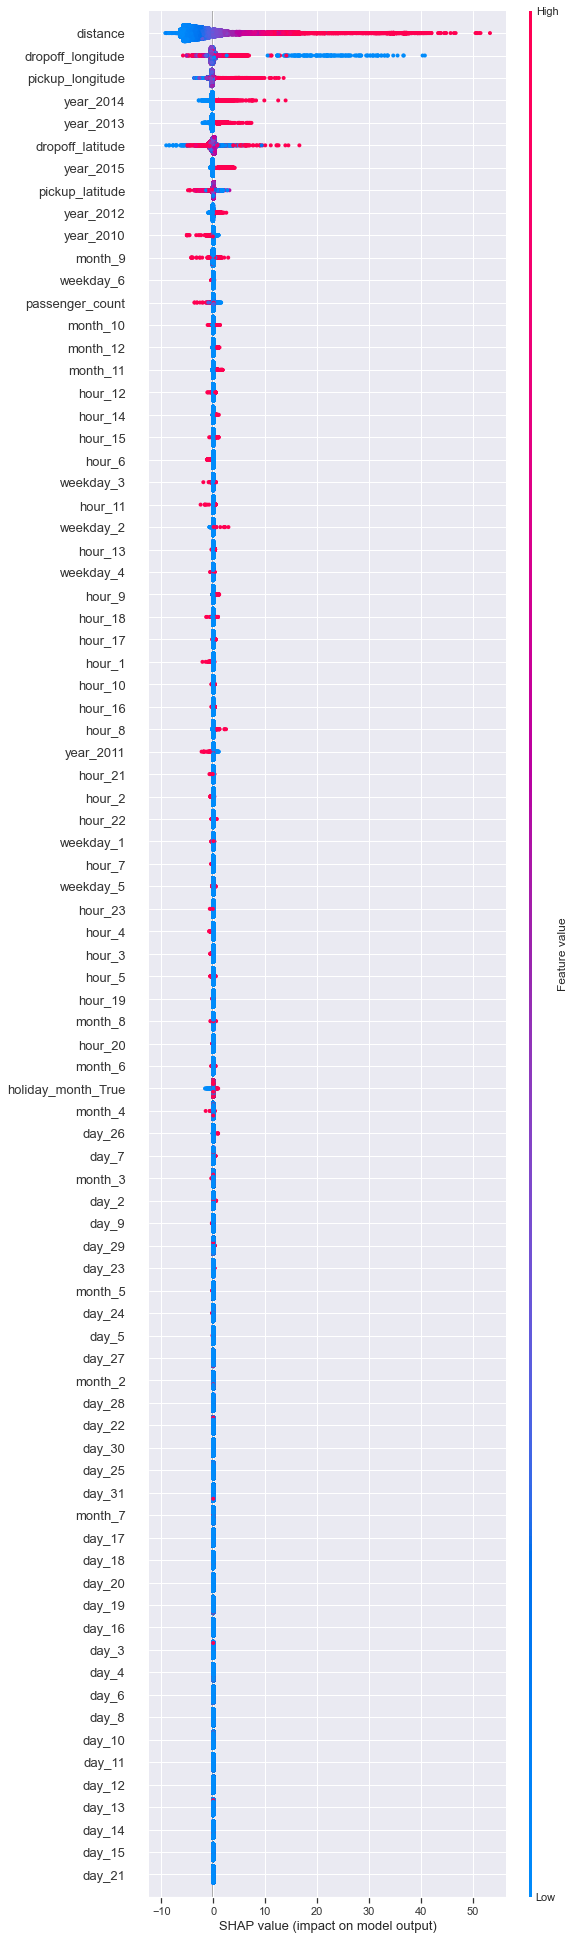

In [102]:
explainer = shap.TreeExplainer(hgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values = shap_values, features = X_test, feature_names = column_names, max_display = len(column_names))